# **Authors: Davy SIMEU, Romin DURAND, Joyce TCHAMDJOU**

# Import des librairies

In [133]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt

# Récupération des données

## Utilitaires / Routines

In [134]:
def char_to_index(char):
    ascii = ord(char)
    if 48 <= ascii <= 57: # 0, 1, ..., 9
        return ascii-48
    elif 65 <= ascii <= 90: # A, B, ..., Z
        return ascii-65+10
    elif 97 <= ascii <= 122: # a, b, ..., z
        return ascii-97 + 10
    else:
        print('Error: {} is not a digit or a letter'.format(char))
        return -1

def index_to_char(index):
    if 0 <= index <= 9: # Digits
        return str(index)
    elif 10 <= index <= 35: # Letters
        return str(chr(index-10+65))

def plot_random_sample_of_each_char(X, n_sample_per_char=39, height=20, width=16, ncol=3):
    n, _ = X.shape
    if n%n_sample_per_char != 0:
        print('Warning: first dimension of X should be '
              + 'a multiple of n_sample_per_char={}'.format(n_sample_per_char))

    n_char = n//n_sample_per_char
    nrow = n_char//ncol + int(n_char%ncol>0)
    fig, axs = plt.subplots(nrow, ncol)
    for i in range(nrow*ncol):
        if nrow==1:
            ax = axs[i%ncol]
        else:
            ax = axs[i//ncol,i%ncol]

        if i < n_char:
            rand_ind = np.random.randint(i*n_sample_per_char, (i+1)*n_sample_per_char)
            rand_char = X[rand_ind]
            img = rand_char.reshape(height, width)
            ax.matshow(img)
            ax.axis('off')
        else:
            fig.delaxes(ax)

    plt.tight_layout()
    
def plot_err(err_history):
    plt.figure(figsize=(13, 7))
    plt.plot(err_history)
    plt.xlabel('Epochs')
    plt.ylabel('Reconstruction error (RMSE)')
    plt.show()

Dans cette partie, on implémente la fonction ``lire_alpha_digit`` permettant de récupérer les données souhaitées au bon format.

In [135]:
def lire_alpha_digit(characters, n_sample_per_char=39, height=20, width=16):
    f = scipy.io.loadmat('binaryalphadigs.mat')
    data = f['dat']

    char_indices = [char_to_index(char) for char in characters if char_to_index(char)!=-1]
    char_indices = np.unique(char_indices)

    N_char = len(char_indices)
    n = n_sample_per_char*N_char
    p = height*width 

    X = np.zeros((n, p))
    for i, idx in enumerate(char_indices):
        for j in range(n_sample_per_char):
            k = i*n_sample_per_char + j
            line = data[idx, j].flatten()
            X[k] = line

    return X

## Exemple de chargement de données

shape of X: (234, 320)


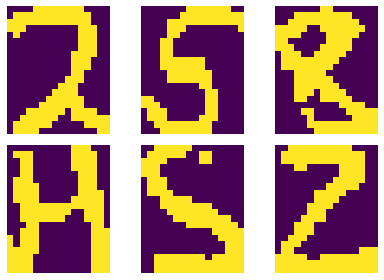

In [136]:
X = lire_alpha_digit('258SHZ')
print('shape of X: {}'.format(X.shape))
plot_random_sample_of_each_char(X)

# Création de la classe RBM

In [257]:
class RBM():
    def __init__(self, p, q, var=1e-2):
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.W = np.random.normal(0, 1, size=(p, q))*np.sqrt(var)
        self.q = q
        self.p = p

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def entree_sortie(self, X):
        return self.sigmoid(X @ self.W + self.b)

    def sortie_entree(self, H):
        return self.sigmoid(H @ self.W.T + self.a)

    def train(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=True):
        if verbose:
            print("Beginning training of the RBM...")
        n, p = X.shape
        err_history = []
        for epoch in range(nb_epoch):
            np.random.shuffle(X)
            
            for batch in range(0, n, batch_size):
                X_batch = X[batch:batch+batch_size]
                current_bs = X_batch.shape[0]

                # Calcul de v_0, v_1, p(v|h) et p(h|v)
                v_0 = X_batch 
                ph_v_0 = self.entree_sortie(v_0) 
                h_0 = (np.random.random((current_bs, self.q)) < ph_v_0).astype(int) 
                pv_h_0 = self.sortie_entree(h_0) 
                v_1 = (np.random.random((current_bs, p)) < pv_h_0).astype(int) 
                ph_v_1 = self.entree_sortie(v_1) 

                # Calcul du gradient (des dérivées partielles)
                grad_a = np.sum(v_0 - v_1, axis=0) 
                grad_b = np.sum(ph_v_0 - ph_v_1, axis=0) 
                grad_W = v_0.T @ ph_v_0 - v_1.T @ ph_v_1

                # Mise à jour des paramètres
                self.W += lr/current_bs * grad_W
                self.a += lr/current_bs * grad_a
                self.b += lr/current_bs * grad_b

            H = self.entree_sortie(X)
            X_rec = self.sortie_entree(H)

            err = np.mean((X-X_rec)**2)**.5
            err_history.append(err)                
                
            if epoch % epoch_per_plot == 0 and verbose:
                print('Epoch {}/{} - RMSE: {:.4f}'.format(epoch+1, nb_epoch, err))
                rand_idx = np.random.randint(n)
                original_img = X[rand_idx].reshape(height, width)
                reconstructed_img = X_rec[rand_idx].reshape(height, width)
                
                _, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 2))
                ax1.imshow(original_img)
                ax1.axis('off')
                ax1.set_title("Original")
                
                ax2.imshow(reconstructed_img)
                ax2.axis('off')
                ax2.set_title("Reconstructed")
                plt.tight_layout()
                plt.show()

        return err_history

    def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
        p, q = self.W.shape
        nb_images = nrow*ncol

        _, axs = plt.subplots(nrow, ncol, figsize=(10, 5))
        for i in range(nb_images):
            v = (np.random.random(p) < thresh).astype(int)
            for _ in range(nb_iter):
                ph_v = self.entree_sortie(v) 
                h = (np.random.random(q) < ph_v).astype(int)
                pv_h = self.sortie_entree(h)
                v = (np.random.random(p) < pv_h).astype(int)

            image = v.reshape(height, width)
            axs[i//ncol, i%ncol].imshow(image)
            axs[i//ncol, i%ncol].axis('off')
        plt.tight_layout()
        
        
    def show_filter(self, height=20, ncol=5, nrow=2):
        idxs = np.random.randint(self.q, size=ncol*nrow)
        plt.figure(figsize=(10, 5))
        for i, idx in enumerate(idxs):
            weights = self.W[:, idx]
            filter = weights.reshape(height, self.p//height)
            
            plt.subplot(nrow, ncol, i+1)
            plt.axis('off')
            plt.imshow(filter, cmap='Greys')
        plt.tight_layout()

# Utilisation du modèle et analyse
Nous pouvons maintenant entrainer le modèle et étudier son comportement

Dimension des données d'entrées : 320 

Beginning training of the RBM...
Epoch 1/1000 - RMSE: 0.4272


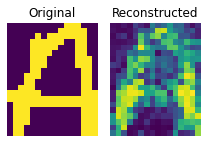

Epoch 101/1000 - RMSE: 0.0488


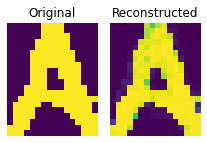

Epoch 201/1000 - RMSE: 0.0218


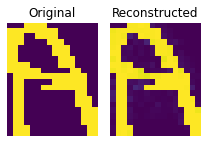

Epoch 301/1000 - RMSE: 0.0141


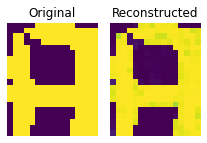

Epoch 401/1000 - RMSE: 0.0103


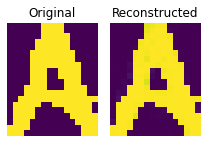

Epoch 501/1000 - RMSE: 0.0082


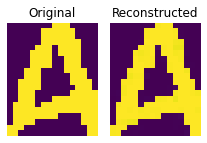

Epoch 601/1000 - RMSE: 0.0070


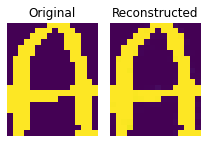

Epoch 701/1000 - RMSE: 0.0058


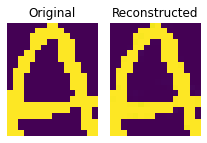

Epoch 801/1000 - RMSE: 0.0051


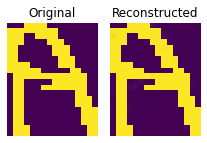

Epoch 901/1000 - RMSE: 0.0046


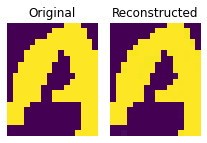

In [258]:
X = lire_alpha_digit('A')
_, p = X.shape
print("Dimension des données d'entrées :", p, "\n")

rbm0 = RBM(p, q=256)
err_history0 = rbm0.train(X, nb_epoch=1000, lr=1e-1, epoch_per_plot=100)

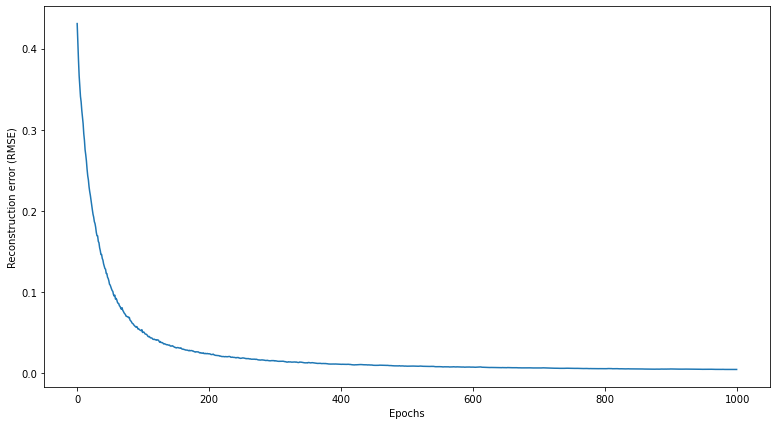

In [7]:
plot_err(err_history0)

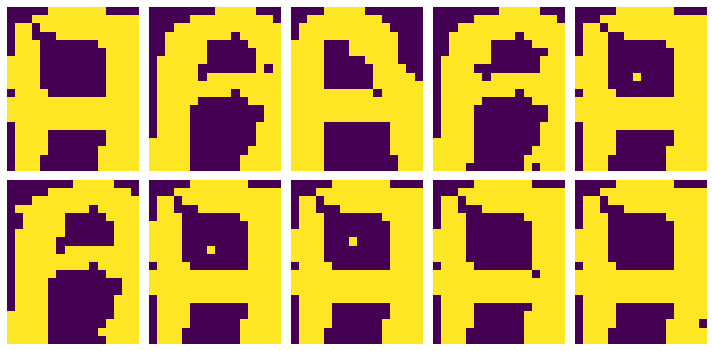

In [8]:
rbm0.generate(nb_iter=10)

In [9]:
lr = 1e-1
lrs = [lr*10, lr, lr/10, lr/100, lr/1000, lr/10000]
err_lr = []
for el in lrs:
    rbm_ = RBM(p, q=256)
    err_history = rbm_.train(X, nb_epoch=500, lr=el, epoch_per_plot=100, verbose=False)
    err_lr.append(err_history)

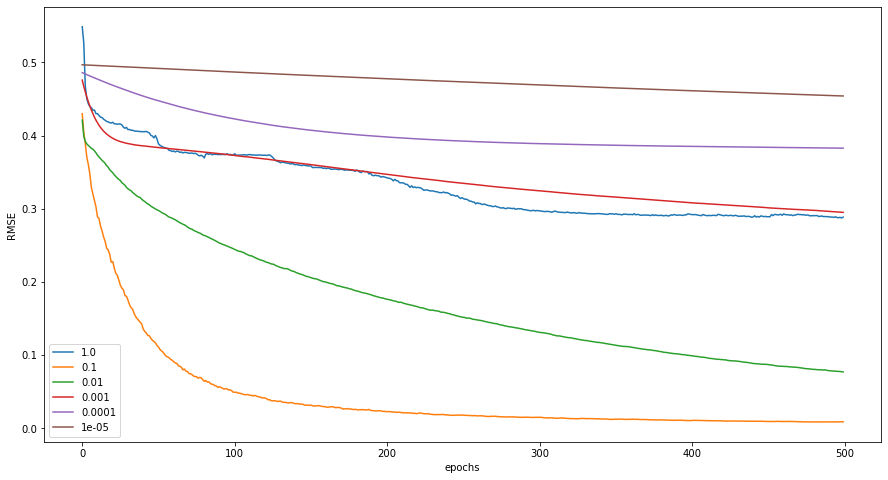

In [10]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_lr):
    plt.plot(el, label=lrs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

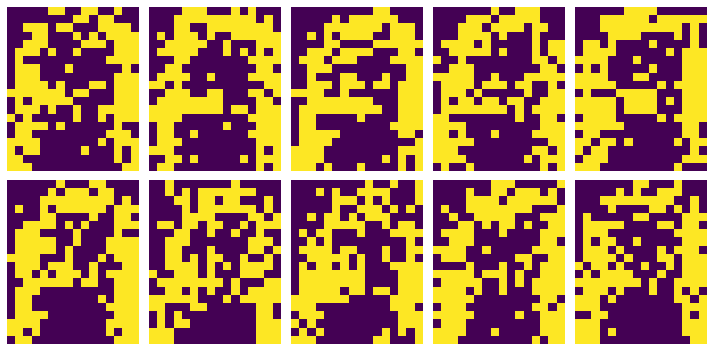

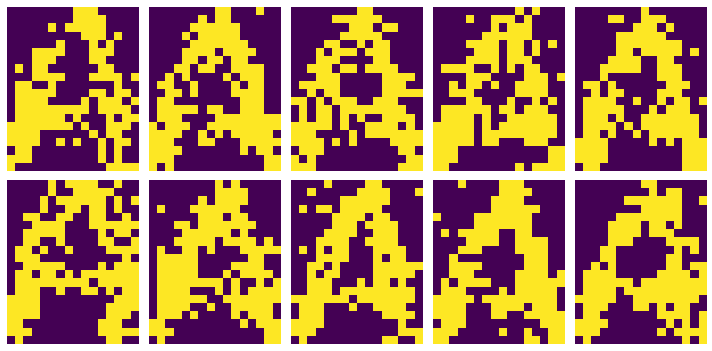

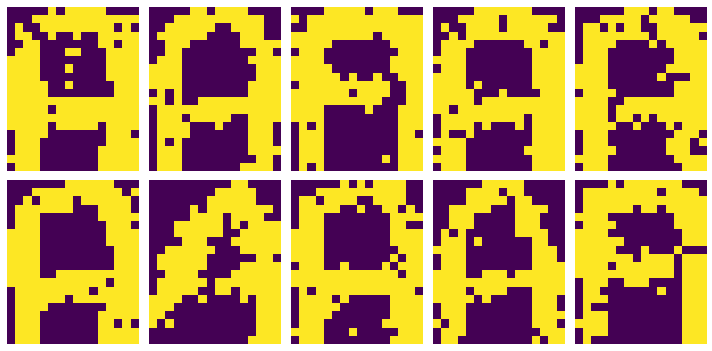

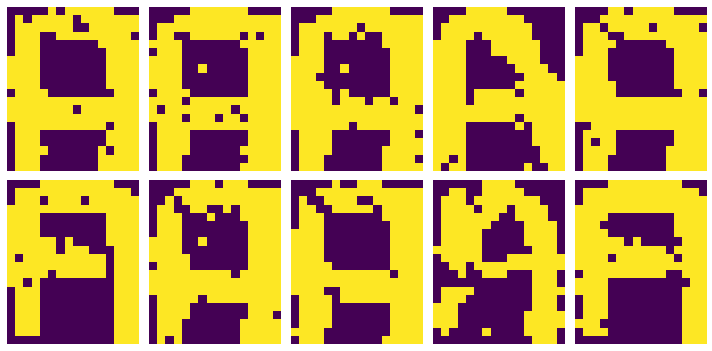

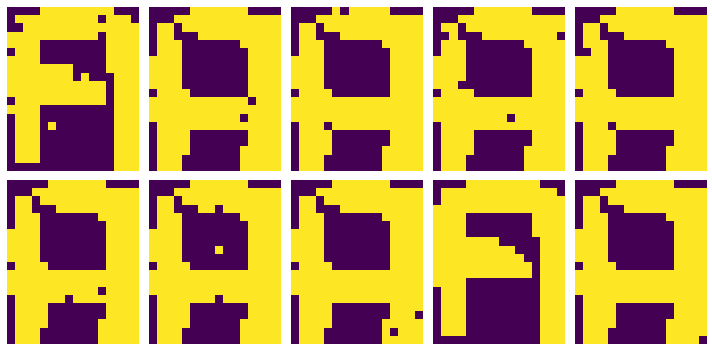

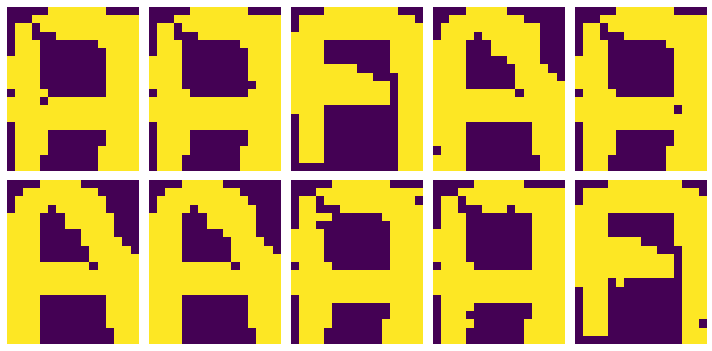

In [11]:
ep = 5
epochs = [ep, ep*2, ep*10, ep*20, ep*100, ep*200]
err_ep = []
for el in epochs:
    rbm_ = RBM(p, q=256)
    err_history = rbm_.train(X, nb_epoch=el, lr=1e-1, epoch_per_plot=100, verbose=False)
    err_ep.append(err_history)
    rbm_.generate(nb_iter=10)

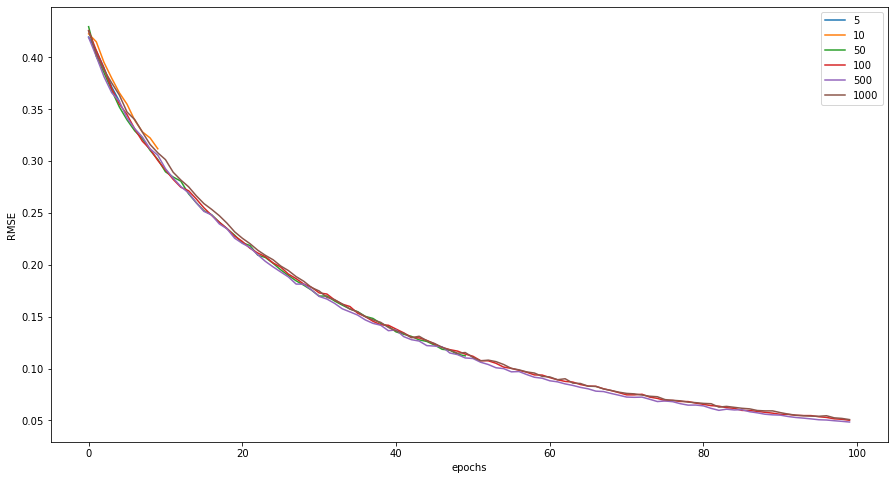

In [12]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_ep):
    plt.plot(el[:100], label=epochs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [13]:
lr = 32
qs = [lr, lr*2, lr*4, lr*8, lr*16, lr*32]
err_q = []
for el in qs:
  rbm_ = RBM(p, q=el)
  err_history = rbm_.train(X, nb_epoch=500, lr=1e-1, epoch_per_plot=100, verbose=False)
  err_q.append(err_history)

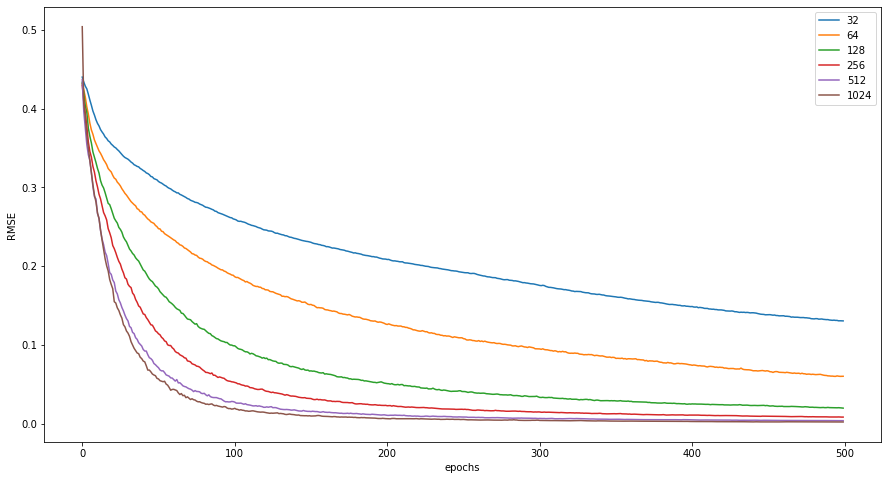

In [14]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_q):
    plt.plot(el, label=qs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Quand on prête attention aux filtres (le filtre étant la matrice des poids d'une unité donnée) du RBM

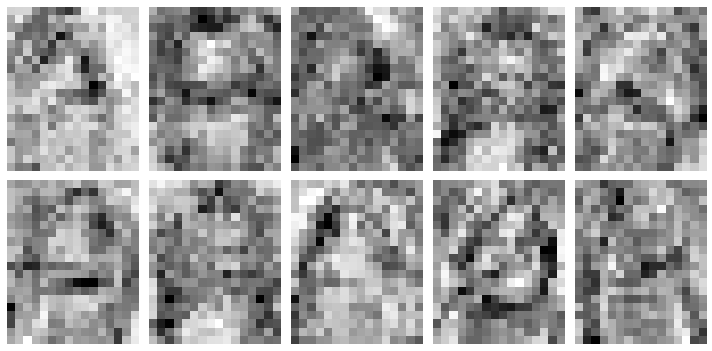

In [15]:
rbm0.show_filter()

# MNIST

In [145]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
n_classes = len(np.unique(train_y))
print("Original dimensions train_X: {}".format(train_X.shape))
print("Original dimensions test_X: {}".format(test_X.shape))
print("Original dimensions train_y: {}".format(train_y.shape))
print("Original dimensions test_y: {}".format(test_y.shape))
print("Number of classes: {}\n".format(n_classes))

N_train = train_X.shape[0]
N_test = test_X.shape[0]
size = train_X.shape[1]*train_X.shape[2]

train_X = train_X.reshape(N_train, size)
test_X = test_X.reshape(N_test, size)
print("Flattened dimensions train_X: {}".format(train_X.shape))
print("Flattened dimensions test_X: {}\n".format(test_X.shape))

thresh = 100
train_X = (train_X>thresh).astype(int)
test_X = (test_X>thresh).astype(int)
X_ = np.vstack((train_X, test_X))
y = np.hstack((train_y, test_y))
print("Full flattened dataset dimensions: {}".format(X_.shape))
print("Full label set dimensions: {}".format(y.shape))

Original dimensions train_X: (60000, 28, 28)
Original dimensions test_X: (10000, 28, 28)
Original dimensions train_y: (60000,)
Original dimensions test_y: (10000,)
Number of classes: 10

Flattened dimensions train_X: (60000, 784)
Flattened dimensions test_X: (10000, 784)

Full flattened dataset dimensions: (70000, 784)
Full label set dimensions: (70000,)


In [139]:
def select_digits_mnist(digits):
    mask = (y == digits[0])
    for label in digits[1:]:
        mask |= (y == label)
        
    for digit in range(10):
        print('{} samples with label {}'.format(sum(y[mask] == digit), digit))
    n, _ = X_[mask].shape
    _, axs = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(9):
        ax = axs[i//3, i%3]
        rand_idx = np.random.randint(n)
        rand_sample = X_[mask][rand_idx]
        rand_sample = rand_sample.reshape(28, 28)
        ax.imshow(rand_sample)
        ax.axis('off')
        ax.set_title('label: {}'.format(y[mask][rand_idx]))
    plt.tight_layout()
    return X_[mask], y[mask]

0 samples with label 0
0 samples with label 1
0 samples with label 2
0 samples with label 3
0 samples with label 4
0 samples with label 5
0 samples with label 6
0 samples with label 7
6825 samples with label 8
0 samples with label 9


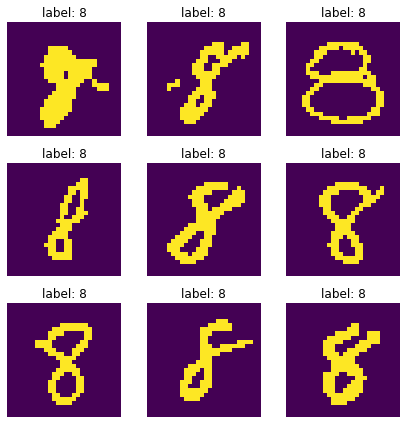

In [140]:
X_train_rbm, y_train_rbm = select_digits_mnist([8])

Beginning training of the RBM...
Epoch 1/100 - RMSE: 0.2382


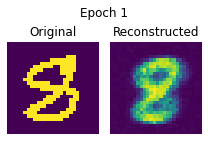

Epoch 11/100 - RMSE: 0.1806


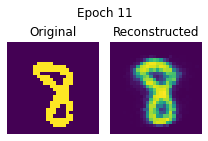

Epoch 21/100 - RMSE: 0.1622


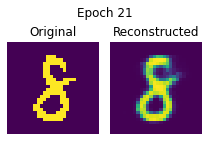

Epoch 31/100 - RMSE: 0.1536


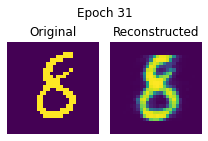

Epoch 41/100 - RMSE: 0.1475


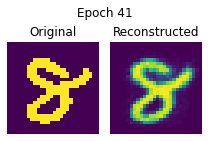

Epoch 51/100 - RMSE: 0.1425


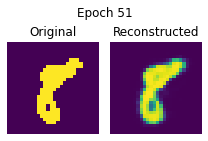

Epoch 61/100 - RMSE: 0.1390


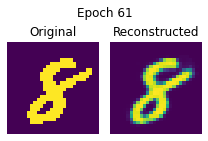

Epoch 71/100 - RMSE: 0.1357


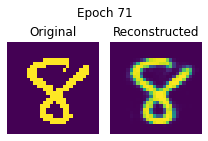

Epoch 81/100 - RMSE: 0.1329


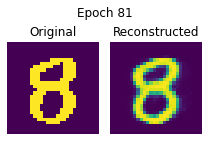

Epoch 91/100 - RMSE: 0.1301


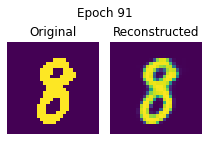

In [141]:
_, p = X_train_rbm.shape

rbm1 = RBM(p, q=512)
err_history1 = rbm1.train(X_train_rbm, nb_epoch=100, batch_size=1024, lr=1e-1, height=28, width=28, epoch_per_plot=10)

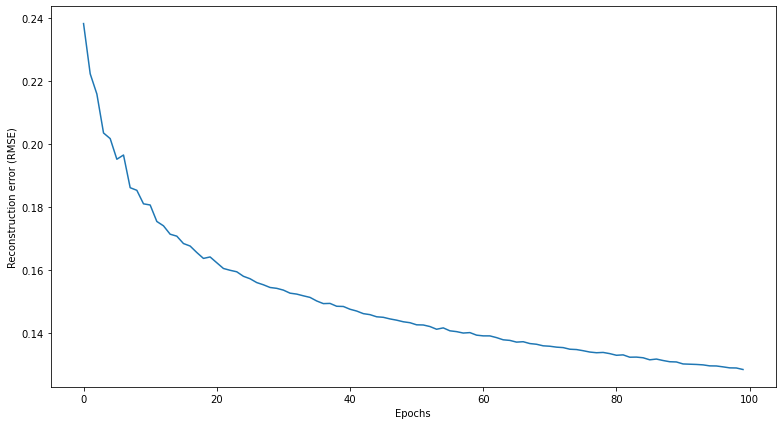

In [142]:
plot_err(err_history1)

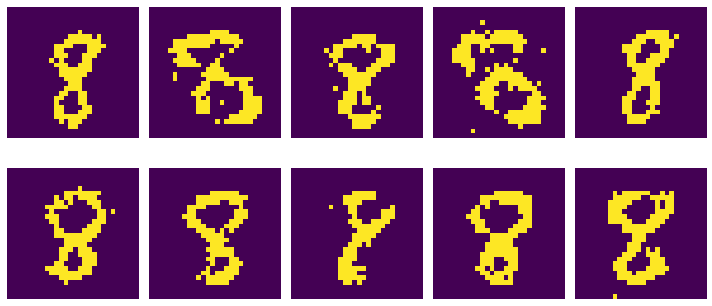

In [143]:
rbm1.generate(nb_iter=1000, thresh=.5, height=28, width=28)

# Création de la classe DBN

In [259]:
class DBN():
    def __init__(self, sizeRBMs, var=1e-2):
        self.n_layers = len(sizeRBMs)-1
        self.layers = [RBM(sizeRBMs[i], sizeRBMs[i+1], var) for i in range(self.n_layers)]

    def pretrain(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=True):
        for epoch in range(nb_epoch):
            tmp = X
            for l in range(self.n_layers):
                _ = self.layers[l].train(tmp, lr, batch_size, 1, height, width, verbose=False)
                tmp = self.layers[l].entree_sortie(tmp)
            
            X_rec = self.sortie_entree(tmp)
            if epoch % epoch_per_plot == 0 and verbose:
                print('Epoch {}/{}'.format(epoch+1, nb_epoch))
                rand_idx = np.random.randint(X.shape[0])
                reconstructed_img = X_rec[rand_idx].reshape(height, width)
                
                plt.figure(figsize=(2, 2))
                plt.imshow(reconstructed_img)
                plt.axis('off')
                plt.title("Reconstructed")
                plt.tight_layout()
                plt.show()
        
    def entree_sortie(self, X):
        for l in range(self.n_layers):
            X = self.layers[l].entree_sortie(X)
        
        return X

    def sortie_entree(self, H):
        for l in range(self.n_layers):
            H = self.layers[-l-1].sortie_entree(H)
        
        return H

    def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
        p = self.layers[0].p
        q = self.layers[-1].q
        nb_images = nrow*ncol

        _, axs = plt.subplots(nrow, ncol, figsize=(10, 5))
        
        for i in range(nb_images):
            v = (np.random.random(p) < thresh).astype(int)
            for _ in range(nb_iter):
                ph_v = self.entree_sortie(v) 
                h = (np.random.random(q) < ph_v).astype(int)
                pv_h = self.sortie_entree(h)
                v = (np.random.random(p) < pv_h).astype(int)

            image = v.reshape(height, width)
            axs[i//ncol, i%ncol].imshow(image)
            axs[i//ncol, i%ncol].axis('off')
        plt.tight_layout()

Epoch 1/100


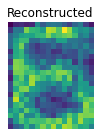

Epoch 11/100


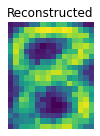

Epoch 21/100


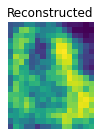

Epoch 31/100


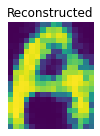

Epoch 41/100


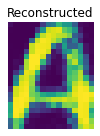

Epoch 51/100


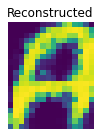

Epoch 61/100


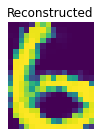

Epoch 71/100


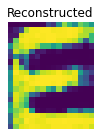

Epoch 81/100


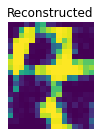

Epoch 91/100


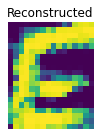

In [261]:
X_dbn = lire_alpha_digit('ABEF486')
_, p = X_dbn.shape

dbn = DBN([p, 160, 640, 280])
dbn.pretrain(X_dbn, nb_epoch=100, epoch_per_plot=10, lr=1e-1)

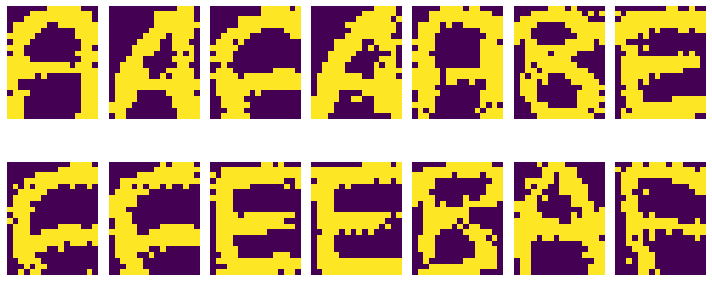

In [265]:
dbn.generate(nb_iter=100, ncol=7)

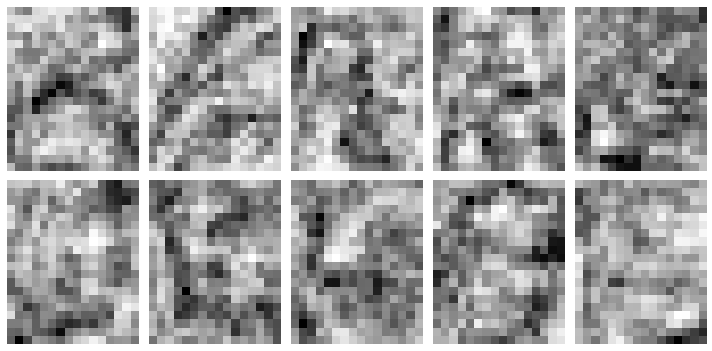

In [267]:
dbn.layers[0].show_filter()

Le DBN réussit à capturer la variabilité de l'ensemble d'apprentissage étant donné qu'après entraînement il génère plusieurs caractères différents (parmi ceux appris bien sûr)

Beginning training of the RBM...
Epoch 1/100 - RMSE: 0.3980


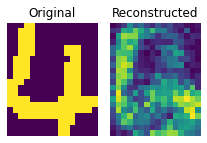

Epoch 11/100 - RMSE: 0.2270


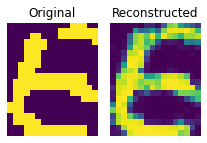

Epoch 21/100 - RMSE: 0.1630


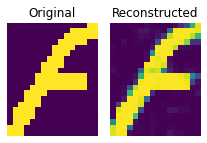

Epoch 31/100 - RMSE: 0.1189


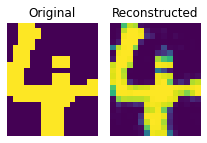

Epoch 41/100 - RMSE: 0.0895


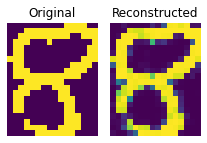

Epoch 51/100 - RMSE: 0.0697


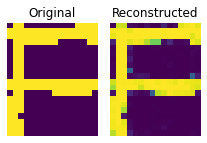

Epoch 61/100 - RMSE: 0.0554


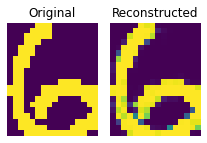

Epoch 71/100 - RMSE: 0.0451


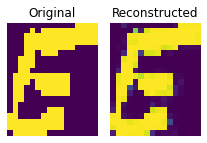

Epoch 81/100 - RMSE: 0.0374


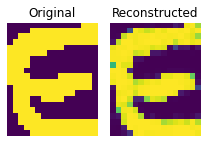

Epoch 91/100 - RMSE: 0.0321


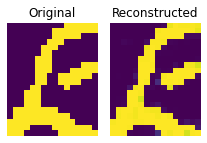

In [276]:
# Essayons de générer à l'aide du seul RBM
rbm = RBM(p, 512)
_ = rbm.train(X_dbn, nb_epoch=100, lr=1e-1, epoch_per_plot=10, verbose=True)

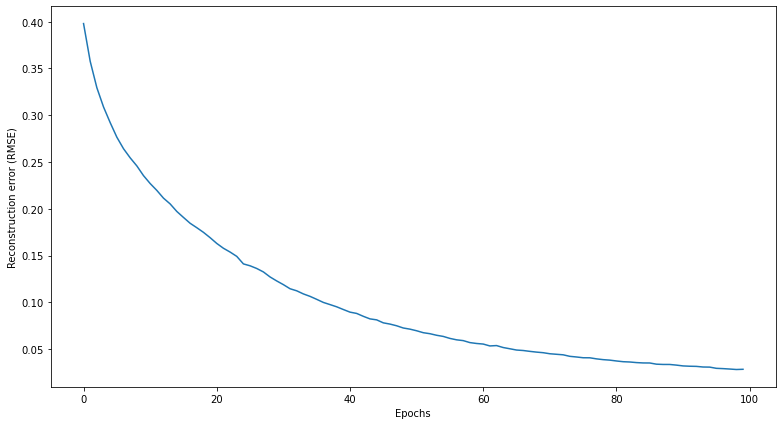

In [277]:
plot_err(_)

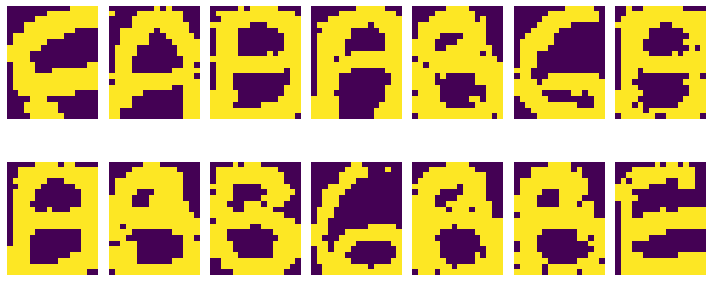

In [279]:
rbm.generate(nb_iter=100, ncol=7)

Visiblement le RBM aussi reussit bien à capturer l'exhaustivité de l'ensemble d'apprentissage.... C'est surprenant et bizarre !

# Création de la classe DNN

In [229]:
class DNN():
    def __init__(self, n_classes, dim_layers=None, dbn=None):
        self.n_classes = n_classes
        if dbn is not None:
            self.dbn = dbn
            self.classifier = RBM(dbn.layers[-1].q, n_classes)
            self.n_layers = dbn.n_layers
        elif dim_layers is not None:
            self.dbn = DBN(dim_layers)
            self.classifier = RBM(dim_layers[-1], n_classes)
            self.n_layers = len(self.dbn.layers)
        else:
            print("Error: you need to either define dim_layers (list of weights dimensions) or load a pretrained dbn")
            
    def compute_softmax(self, x):
        z = x-x.max(axis=1, keepdims=True)
        z = np.exp(z)
        
        return z/z.sum(axis=1, keepdims=True)
    
    def entree_sortie(self, X):
        outputs = []
        for i in range(self.n_layers):
            X = self.dbn.layers[i].entree_sortie(X)
            outputs.append(X)
        
        X = self.classifier.entree_sortie(X)
        probs = self.compute_softmax(X)
        
        return outputs, probs
        
    def backpropagate(self, X, y, lr=1e-1, batch_size=2048, nb_epoch=100, height=28, width=28, verbose=False):
        n, _ = X.shape
        losses = []
        for epoch in range(nb_epoch):
            nllloss = 0
            print(f"\rEpoch {epoch+1}/{nb_epoch}", end="")
            for batch in range(0, n, batch_size):
                X_batch = X[batch:batch+batch_size]
                y_batch = y[batch:batch+batch_size]
                current_size = X_batch.shape[0]
                outputs, y_hat = self.entree_sortie(X_batch)
                
                tmp = y_hat - y_batch
                dW = outputs[-1].T @ tmp 
                db = tmp.sum(axis=0)
                self.classifier.W -= lr/current_size*dW
                self.classifier.b -= lr/current_size*db
                
                nllloss += -np.sum(y_batch * np.log(y_hat))
                for i in range(self.n_layers):
                    if i == 0:
                        tmp = (tmp @ self.classifier.W.T) * (outputs[-i-1] * (1-outputs[-i-1]))
                        dW = outputs[-i-2].T @ tmp
                        db = tmp.sum(axis=0)
                        self.dbn.layers[-i-1].W -= lr/current_size*dW
                        self.dbn.layers[-i-1].b -= lr/current_size*db
                    elif i < self.n_layers-1:
                        tmp = (tmp @ self.dbn.layers[-i].W.T) * (outputs[-i-1] * (1-outputs[-i-1]))
                        dW = outputs[-i-2].T @ tmp
                        db = tmp.sum(axis=0)
                        self.dbn.layers[-i-1].W -= lr/current_size*dW
                        self.dbn.layers[-i-1].b -= lr/current_size*db
                    else:
                        tmp = (tmp @ self.dbn.layers[-i].W.T) * (outputs[-i-1] * (1-outputs[-i-1]))
                        dW = X_batch.T @ tmp
                        db = tmp.sum(axis=0)
                        self.dbn.layers[-i-1].W -= lr/current_size*dW
                        self.dbn.layers[-i-1].b -= lr/current_size*db
                        
            losses.append(nllloss/n)
        
        return losses

In [181]:
def select_digits_toclassify(digits):
    mask1 = (train_y == digits[0])
    for label in digits[1:]:
        mask1 |= (train_y == label)
    
    mask2 = (test_y == digits[0])
    for label in digits[1:]:
        mask2 |= (test_y == label)
    
    for digit in range(10):
        print('{} samples with label {}'.format(sum(train_y[mask1] == digit), digit))
    n, _ = train_X[mask1].shape
    _, axs = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(9):
        ax = axs[i//3, i%3]
        rand_idx = np.random.randint(n)
        rand_sample = train_X[mask1][rand_idx]
        rand_sample = rand_sample.reshape(28, 28)
        ax.imshow(rand_sample)
        ax.axis('off')
        ax.set_title('label: {}'.format(train_y[mask1][rand_idx]))
    plt.tight_layout()
    return train_X[mask1], pd.get_dummies(train_y)[mask1].values, test_X[mask2], pd.get_dummies(test_y)[mask2].values

0 samples with label 0
0 samples with label 1
0 samples with label 2
0 samples with label 3
0 samples with label 4
0 samples with label 5
5918 samples with label 6
0 samples with label 7
0 samples with label 8
0 samples with label 9


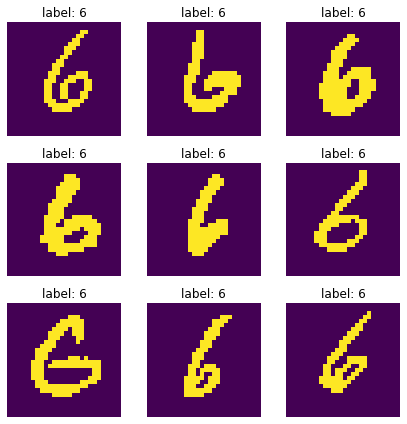

In [242]:
X_train_dnn, y_train_dnn, X_test_dnn, y_test_dnn = select_digits_toclassify([6])

Epoch 1/50 - RMSE: 0.2899


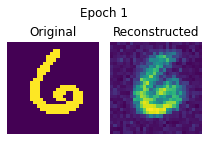

Epoch 11/50 - RMSE: 0.2957


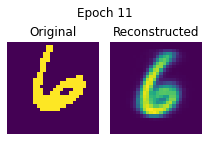

Epoch 21/50 - RMSE: 0.3026


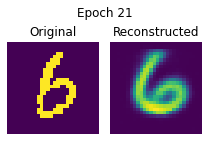

Epoch 31/50 - RMSE: 0.3074


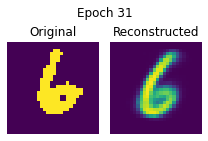

Epoch 41/50 - RMSE: 0.3108


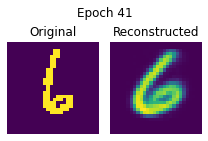

In [243]:
_, p = X_train_dnn.shape

dbn1 = DBN([p, 160, 640, 280])
err_history1 = dbn1.pretrain(X_train_dnn, nb_epoch=50, epoch_per_plot=10, batch_size=2048, lr=1e-1, height=28, width=28)

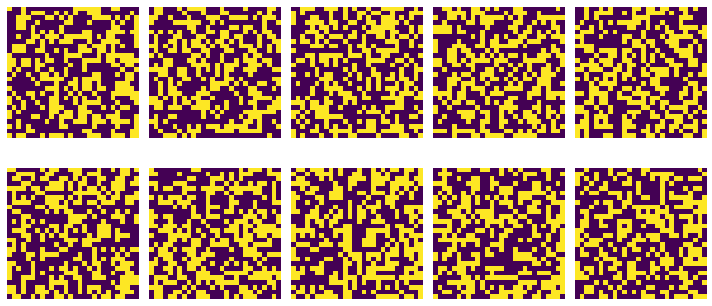

In [244]:
dbn1.generate(nb_iter=100, height=28, width=28)

In [245]:
dnn1 = DNN(n_classes, dim_layers=[p, 160, 640, 280])
logloss1 = dnn1.backpropagate(X_train_dnn, y_train_dnn, nb_epoch=5)

Epoch 5/5

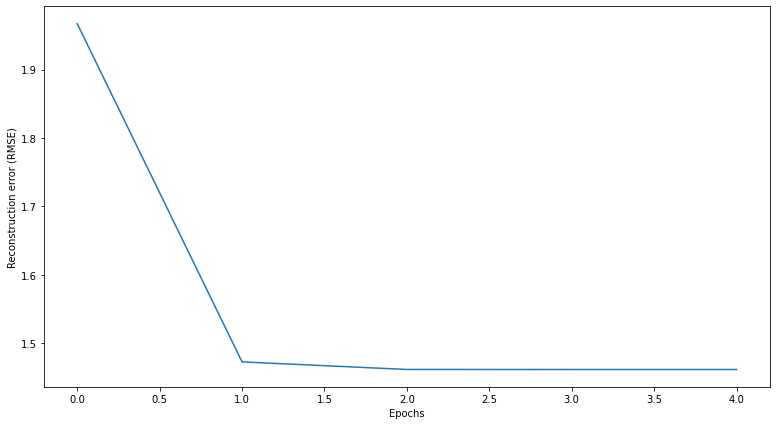

In [246]:
plot_err(logloss1)

In [241]:
_, y_hat1 = dnn1.entree_sortie(X_test_dnn)
print(np.mean(y_hat1==y_test_dnn, axis=0))
print(np.argmax(y_hat1[:100], axis=1))
y_test_dnn[:100]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

In [224]:
dnn2 = DNN(n_classes, dbn=dbn1)
logloss2 = dnn2.backpropagate(X_train_dnn, y_train_dnn, nb_epoch=20)

Epoch 5/5

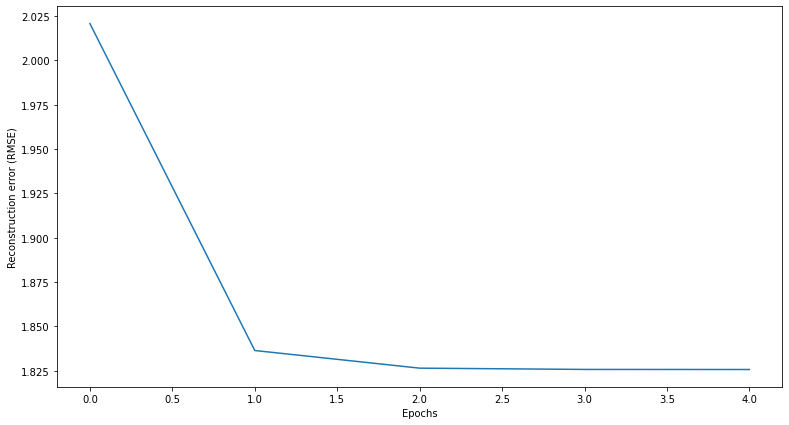

In [225]:
plot_err(logloss2)

In [228]:
_, y_hat2 = dnn2.entree_sortie(X_test_dnn)
print(np.mean(y_hat2==y_test_dnn, axis=0))
print(np.argmax(y_hat2[:100], axis=1))
y_test_dnn[:100]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

In [211]:
for el in dnn2.dbn.layers:
    print(el.W)
    print()

[[-0.11571226 -0.13661272  0.08682682 ... -0.31034774  0.14248832
  -0.1195762 ]
 [-0.1510172  -0.00917007 -0.13394577 ...  0.20595312  0.01615583
  -0.06536303]
 [-0.03044338 -0.12559199  0.021262   ...  0.09926886 -0.10544812
  -0.01425369]
 ...
 [-0.13320126 -0.21251063  0.05683741 ... -0.08187479 -0.05673295
  -0.035271  ]
 [ 0.05279212 -0.12334428 -0.1996501  ...  0.04394575 -0.05702237
  -0.13461998]
 [ 0.01457101 -0.08010773 -0.07312489 ...  0.01345956 -0.13074966
   0.02031442]]

[[ 0.00639665 -0.11467881  0.06962316 ...  0.14105389 -0.03124213
  -0.03474499]
 [ 0.16023824  0.03191611 -0.01343062 ...  0.01496429 -0.07312248
   0.05034454]
 [-0.0436593  -0.05980409 -0.03893527 ... -0.06083753  0.01487097
  -0.0585436 ]
 ...
 [-0.0537595  -0.00615413 -0.01221562 ...  0.12099529 -0.03631315
   0.0763075 ]
 [-0.04196331 -0.02980496  0.04792955 ... -0.04442096  0.04678102
  -0.06036252]
 [-0.07029281 -0.01057399  0.08506929 ... -0.2417624  -0.09054571
  -0.00293686]]

[[-0.08557655 